# IMPALA Grid Search

This notebook is a bit unusual, because instead of reading the normal logs of torchbeast is parsing the results from the slurm output. 

This is because I made a grid search with 24 combinations of learning rates, optimiziers and batch sizes on the mini-game CollectMineralShards in order to understand how the performance varies in all these cases, but unfortunately the default directory in which evrything is saved is torchbeast-YYYYMMDD-HHMMSS and since I executed everything on the CSC cluster many jobs started the same exact second, hence overriding each other's directories.

This is why I'm doing this manual retrieval effort from the slurm raw output and I'm taking the hyper-parameters values out of nothing.


In [37]:
import os
import sys
sys.path.insert(0, "../")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## From slurm output to dictionaries saved on file

In [2]:
# executed from ../logs/cluster_results/ dir, fix ID = f[6:13] counting backwards if needed
def get_info_from_slurm_file(f):
    
    def get_Steps(f):
        ID = f[6:13]
        cmd = "grep 'Steps' %s >> %s_tmp.txt"%(f, ID)
        clean_cmd = "rm %s_tmp.txt"%ID
        os.system(clean_cmd)
        os.system(cmd)
        file_in = open('%s_tmp.txt'%ID, 'r') 
        lines = file_in.readlines() 
        steps = []
        for l in lines:
            tokens = l.split(' ')
            steps.append(eval(tokens[5]))
        os.system(clean_cmd)
        return np.array(steps)

    def get_variable(f, var_name):
        possible_variables = ["baseline_loss", "entropy_loss", "pg_loss", "mean_episode_return", "total_loss"]
        assert var_name in possible_variables, \
            ("Expected one of ", possible_variables, "got "+var_name)

        ID = f[6:13]
        cmd = "grep '%s' %s >> %s_tmp.txt"%(var_name, f, ID)
        clean_cmd = "rm %s_tmp.txt"%ID
        os.system(clean_cmd)
        os.system(cmd)
        file_in = open('%s_tmp.txt'%ID, 'r') 
        lines = file_in.readlines() 
        x = []
        for l in lines:
            tokens = l.split(' ')
            if len(tokens) > 5:
                continue
            value = tokens[-1].split(',')[0]
            if value == 'nan':
                x.append(np.NaN)
            else:
                x.append(eval(value))
        os.system(clean_cmd)
        return np.array(x)

    results = {}
    results['steps'] = get_Steps(f)
    L = len(results['steps'])
    var_names = ["baseline_loss", "entropy_loss", "pg_loss"]
    for var_name in var_names:
        results[var_name] = get_variable(f, var_name)
        if len(results[var_name]) < L:
            L = len(results[var_name])
    results['score'] = get_variable(f, "mean_episode_return")
    if len(results['score']) < L:
            L = len(results['score'])
    # make sure all results have same length
    for k in results.keys():
        results[k] = results[k][:L]
    return results

In [5]:
# slurm-<ID>.out -> results_<ID>.npy - need to execute just once
disable = True
if not disable:
    # executed from ../logs/cluster_results/ dir, fix os.listdir() if needed
    filenames = os.listdir()
    slurm_files = [f for f in filenames if "slurm" in f]
    for f in slurm_files:
        results = get_info_from_slurm_file(f)
        ID = f[6:13]
        np.save("results_%s"%ID, results)

## Grid search analysis

In [27]:
# slurm-ID: HPs + timing in minutes (manually looked at)
HPs_dict = {
    '3062790':{'batch_size':20, 'learning_rate':0.001, 'optim':'RMSprop','time':118.22},
    '3062793':{'batch_size':20, 'learning_rate':0.001, 'optim':'Adam','time':121.66},
    '3062794':{'batch_size':20, 'learning_rate':0.0007, 'optim':'RMSprop','time':119.16},
    '3062795':{'batch_size':20, 'learning_rate':0.0007, 'optim':'Adam','time':120.55},
    '3062796':{'batch_size':20, 'learning_rate':0.0003, 'optim':'RMSprop','time':123.82},
    '3062797':{'batch_size':20, 'learning_rate':0.0003, 'optim':'Adam','time':121.85},
    '3062798':{'batch_size':20, 'learning_rate':0.0001, 'optim':'RMSprop','time':123.90},
    '3062802':{'batch_size':20, 'learning_rate':0.0001, 'optim':'Adam','time':117.83},
    
    '3062805':{'batch_size':40, 'learning_rate':0.001, 'optim':'RMSprop','time':138.04},
    '3062808':{'batch_size':40, 'learning_rate':0.001, 'optim':'Adam','time':141.87},
    # here I used batch size of 20 for error but was an interesting finiding because is twice as fast
    '3062817':{'batch_size':20, 'learning_rate':0.0007, 'optim':'RMSprop','time':55.11}, 
    '3062821':{'batch_size':40, 'learning_rate':0.0007, 'optim':'Adam','time':137.78},
    '3062825':{'batch_size':40, 'learning_rate':0.0003, 'optim':'RMSprop','time':142.73},
    '3062827':{'batch_size':40, 'learning_rate':0.0003, 'optim':'Adam','time':136.60},
    '3062829':{'batch_size':40, 'learning_rate':0.0001, 'optim':'RMSprop','time':134.90},
    '3062831':{'batch_size':40, 'learning_rate':0.0001, 'optim':'Adam','time':135.28},
    
    '3062832':{'batch_size':60, 'learning_rate':0.001, 'optim':'RMSprop','time':163.74},
    '3062834':{'batch_size':60, 'learning_rate':0.001, 'optim':'Adam','time':180.00}, # runned out of time (3h)
    '3062837':{'batch_size':60, 'learning_rate':0.0007, 'optim':'RMSprop','time':163.10},
    '3062838':{'batch_size':60, 'learning_rate':0.0007, 'optim':'Adam','time':162.53},
    '3062839':{'batch_size':60, 'learning_rate':0.0003, 'optim':'RMSprop','time':167.03},
    '3062840':{'batch_size':60, 'learning_rate':0.0003, 'optim':'Adam','time':166.37},
    '3062841':{'batch_size':60, 'learning_rate':0.0001, 'optim':'RMSprop','time':164.44},
    '3062843':{'batch_size':60, 'learning_rate':0.0001, 'optim':'Adam','time':172.61}
}

First of all we are going to compute the asymptotic performance of each HPs combination and attach it as an entry to HPs_dict.

In [29]:
load_dir = '../logs/cluster_results'
scores = {}
for k in HPs_dict.keys():
    scores[k] = {}
    results = np.load('%s/results_%s.npy'%(load_dir, k), allow_pickle=True).item()
    # take last 100 updates, mask out NaN entries 
    # (when no terminal state was present in any trajectory used for update)
    # and store the mean value
    last100 = results['score'][-100:]
    scores[k]['score'] = np.mean(last100[~np.isnan(last100)])

In [30]:
# merging dictionaries
HPs_dict = {k:{**HPs_dict[k], **scores[k]} for k in HPs_dict.keys()}

In [33]:
# save to file 
np.save("%s/HPs_dict"%load_dir, HPs_dict)

In [36]:
# from dict to arrays
batch_sizes = np.array([HPs_dict[k]['batch_size'] for k in HPs_dict.keys()])
learning_rates = np.array([HPs_dict[k]['learning_rate'] for k in HPs_dict.keys()])
optims = np.array([HPs_dict[k]['optim'] for k in HPs_dict.keys()])
times = np.array([HPs_dict[k]['time'] for k in HPs_dict.keys()])
scores = np.array([HPs_dict[k]['score'] for k in HPs_dict.keys()])

In [45]:
batch_sizes.reshape(3,8)

array([[20, 20, 20, 20, 20, 20, 20, 20],
       [40, 40, 20, 40, 40, 40, 40, 40],
       [60, 60, 60, 60, 60, 60, 60, 60]])

In [43]:
learning_rates

array([0.001 , 0.001 , 0.0007, 0.0007, 0.0003, 0.0003, 0.0001, 0.0001,
       0.001 , 0.001 , 0.0007, 0.0007, 0.0003, 0.0003, 0.0001, 0.0001,
       0.001 , 0.001 , 0.0007, 0.0007, 0.0003, 0.0003, 0.0001, 0.0001])

In [46]:
scores

array([25.31836767, 62.19387849, 22.74277792, 64.41730917, 60.58115803,
       55.90738914, 44.12970161, 54.30000081, 60.51260086, 21.16137181,
       62.11675427, 23.04405293, 62.59367428, 64.71345451, 28.62407755,
       54.06015175, 45.22983105, 30.02248594, 59.66729107, 29.61335154,
       62.8462706 , 72.2307209 , 59.9302393 , 60.92408504])

In [44]:
scores.reshape(3,8)

array([[25.31836767, 62.19387849, 22.74277792, 64.41730917, 60.58115803,
        55.90738914, 44.12970161, 54.30000081],
       [60.51260086, 21.16137181, 62.11675427, 23.04405293, 62.59367428,
        64.71345451, 28.62407755, 54.06015175],
       [45.22983105, 30.02248594, 59.66729107, 29.61335154, 62.8462706 ,
        72.2307209 , 59.9302393 , 60.92408504]])

In [47]:
unique_batch_sizes = np.unique(batch_sizes)
unique_batch_sizes

array([20, 40, 60])

In [49]:
unique_lr = np.unique(learning_rates)[::-1]
unique_lr

array([0.001 , 0.0007, 0.0003, 0.0001])

In [58]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise the

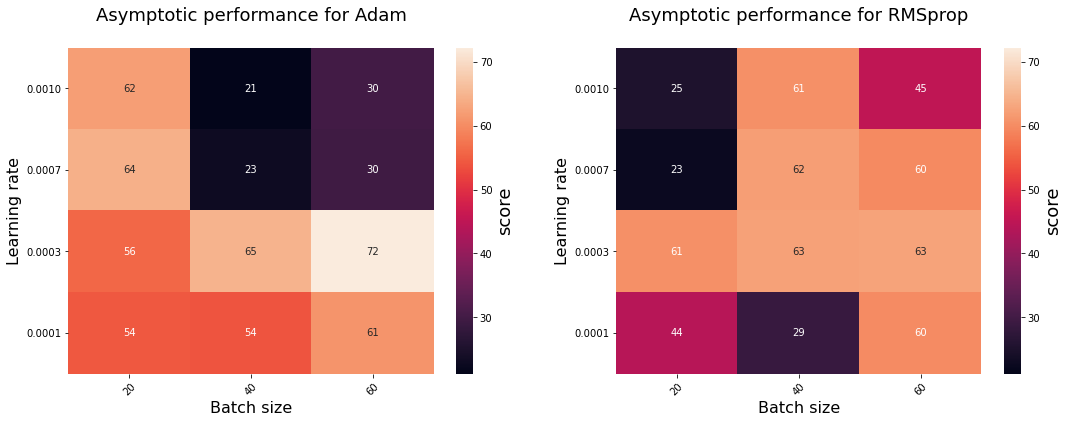

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,6))

# First heat map
adam_scores = scores[optims=="Adam"]
sns.heatmap(adam_scores.reshape(3,4).T, 
            vmin = scores.min(),
            vmax = scores.max(),
            ax = ax1,
            annot = True, 
            cbar_kws = {'label' : 'score'})

B_index = ['%d'%b for b in unique_batch_sizes]
ax1.set_xticklabels(B_index, rotation = 45)
ax1.set_xlabel('Batch size', fontsize = 16)

lr_index = ['%.4f'%lr for lr in unique_lr]
ax1.set_yticklabels(lr_index, rotation = 0)
ax1.set_ylabel('Learning rate', fontsize = 16)
ax1.figure.axes[-1].yaxis.label.set_size(18)

ax1.set_title("Asymptotic performance for Adam\n", fontsize = 18)

# Second heat map
RMS_scores = scores[optims=="RMSprop"]
sns.heatmap(RMS_scores.reshape(3,4).T, 
            vmin = scores.min(),
            vmax = scores.max(),
            ax = ax2,
            annot = True, 
            cbar_kws = {'label' : 'score'})

B_index = ['%d'%b for b in unique_batch_sizes]
ax2.set_xticklabels(B_index, rotation = 45)
ax2.set_xlabel('Batch size', fontsize = 16)

lr_index = ['%.4f'%lr for lr in unique_lr]
ax2.set_yticklabels(lr_index, rotation = 0)
ax2.set_ylabel('Learning rate', fontsize = 16)
ax2.figure.axes[-1].yaxis.label.set_size(18)

ax2.set_title("Asymptotic performance for RMSprop\n", fontsize = 18)

plt.show()

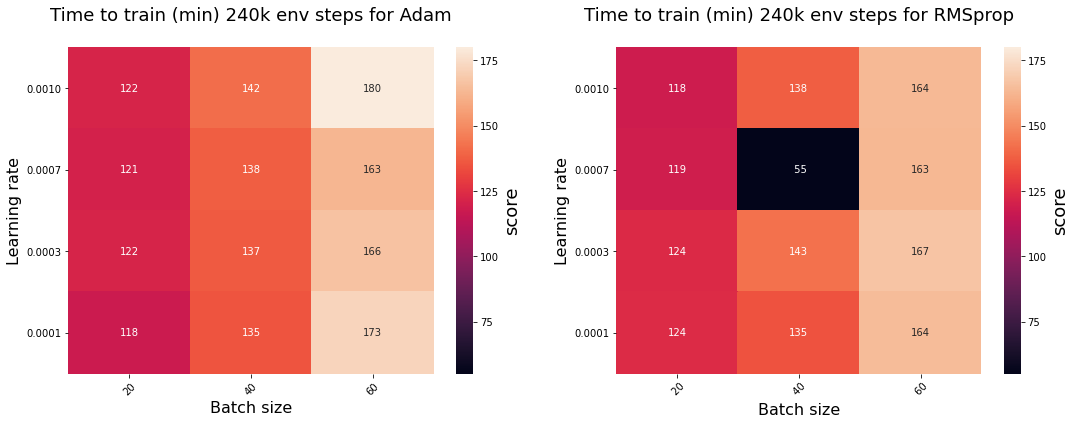

In [76]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,6))

# First heat map
adam_scores = times[optims=="Adam"]
sns.heatmap(adam_scores.reshape(3,4).T, 
            vmin = times.min(),
            vmax = times.max(),
            ax = ax1,
            annot = True, 
            fmt = '3.0f',
            cbar_kws = {'label' : 'score'})

B_index = ['%d'%b for b in unique_batch_sizes]
ax1.set_xticklabels(B_index, rotation = 45)
ax1.set_xlabel('Batch size', fontsize = 16)

lr_index = ['%.4f'%lr for lr in unique_lr]
ax1.set_yticklabels(lr_index, rotation = 0)
ax1.set_ylabel('Learning rate', fontsize = 16)
ax1.figure.axes[-1].yaxis.label.set_size(18)

ax1.set_title("Time to train (min) 240k env steps for Adam\n", fontsize = 18)

# Second heat map
RMS_scores = times[optims=="RMSprop"]
sns.heatmap(RMS_scores.reshape(3,4).T, 
            vmin = times.min(),
            vmax = times.max(),
            ax = ax2,
            annot = True, 
            fmt = '3.0f',
            cbar_kws = {'label' : 'score'})

B_index = ['%3d'%b for b in unique_batch_sizes]
ax2.set_xticklabels(B_index, rotation = 45)
ax2.set_xlabel('Batch size', fontsize = 16)

lr_index = ['%.4f'%lr for lr in unique_lr]
ax2.set_yticklabels(lr_index, rotation = 0)
ax2.set_ylabel('Learning rate', fontsize = 16)
ax2.figure.axes[-1].yaxis.label.set_size(18)

ax2.set_title("Time to train (min) 240k env steps for RMSprop\n", fontsize = 18)

plt.show()